In [1]:
import time
import copy
import random
import sys

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from tqdm import tqdm

%matplotlib inline

In [3]:
epsilon = .5
alpha = 0.05
gamma = 1

ACTIONS = [0,1,2]

num_inv_steps = 3

num_prob_steps = 10

Q_dims = (num_inv_steps, num_prob_steps, len(ACTIONS))

fill_probs = np.linspace(0,1,10)

c = 0

max_iter = float('inf')

actions = {'buy': 2, 'sell': 0, 'hold': 1} 
positions = {'flat': 0, 'long': 2, 'short': 1}

In [4]:
fill_probs

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [5]:
class DataFeed():
    def __init__(self,data_RA):
        self.data_RA = data_RA
        self.rewind()
    def next(self):
        try:
            return self.__gen.__next__()
        except StopIteration as e:
            raise e
    def rewind(self):
        self.__gen = (row for row in self.data_RA)

        csv_path

In [6]:
csv_path = './data/AMZN-L1.csv'
data_RA = np.genfromtxt(csv_path, delimiter =',', dtype=float)
data_generator = DataFeed(data_RA)

In [7]:
def get_initial_state(data_generator):
    data_generator.rewind()
    
    position = positions['flat']
    entry_price = None
    
    ask, ask_depth, bid, bid_depth = data_generator.next()
    
    price = {'bid': bid/1000.0, 'ask': ask/1000.0}
    
    q = bid_depth / (bid_depth + ask_depth)
    q_ind = int(q * num_prob_steps)
    
    initial_state = position, q_ind, price, entry_price
    
    return initial_state

In [8]:
START = get_initial_state(data_generator)
print(START)

(0, 5, {'bid': 2231.8, 'ask': 2239.5}, None)


In [9]:
def step(state, action):
    position, q, price, entry_price = state
    reward = 0
    instant_pnl = 0
    done = False
    
    if fill_probs[q] < np.random.rand():
        fill_bid = True
        fill_ask = False
    else:
        fill_bid = False
        fill_ask = True
    
    if (action == actions['buy']) and (fill_bid):
        reward = -c
        if position == positions['flat']:
            position = positions['long']
            entry_price = price['bid']
        elif position == positions['short']:
            position = positions['flat']
            exit_price = price['bid']
            instant_pnl = entry_price - exit_price
            entry_price = None
        elif position == positions['long']:
            raise ValueError("can't buy, already have")
    
    elif (action == actions['sell'] and fill_ask):
        reward = -c
        
        if position == positions['flat']:
            position = positions['short']
            entry_price = price['ask']
        elif position == positions['long']:
            exit_price = price['ask']
            position = positions['flat']
            instant_pnl = exit_price - entry_price
            entry_price = None
        elif position == positions['short']:
            raise ValueError("Can't sell, already short")
    reward += instant_pnl
    
    try:
        ask, ask_depth, bid, bid_depth = data_generator.next()
        
        price = {'bid': bid/1000.0, 'ask':ask/1000.0}
        
        q = bid_depth/(bid_depth + ask_depth)
        
        q_ind = int(q*num_prob_steps)
    
    except StopIteration as e:
        raise e
    
    next_state = position, q_ind, price, entry_price
    
    return next_state, reward
                        

In [10]:
num_prob_steps

10

In [11]:
print(actions)
state = get_initial_state
print(step(START, 0))
print(step(START, 1))

{'buy': 2, 'sell': 0, 'hold': 1}
((0, 1, {'bid': 2238.1, 'ask': 2239.5}, None), 0)
((0, 5, {'bid': 2237.5, 'ask': 2239.5}, None), 0)


In [12]:
def choose_action(state, q_value,eps=epsilon):
    position, q, price, entry_price = state
    
    if np.random.binomial(1,eps) == 1:
        if position == positions['long']:
            action = np.random.choice([actions['hold'],actions['sell']])
        elif position == positions['short']:
            action = np.random.choice([actions['hold'],actions['buy']])
        else:
            action = np.random.choice([actions['hold'],actions['sell'],actions['buy']])
    
    else:
        if position == positions['long']:
            actions_ = [actions['hold'],actions['sell']]
        elif position == positions['short']:
            actions_ = [actions['hold'], actions['buy']]
        else:
            actions_ = [actions['hold'], actions['buy'], actions['sell']]
        
        values_ = q_value[state[0],state[1],actions_]
        
        action = np.random.choice([actions_[action_] 
                                   for action_, value_ in enumerate(values_)
                                   if value_ == np.max(values_)])
    return action

In [13]:
# Set a random state-action value function
q_value_example = np.random.random(Q_dims) 

# Show the initial state
state = get_initial_state(data_generator)
print(state)

# The action values for the initial state. 
# state[0] is the position; state[1] is the bid fill probability
print(q_value_example[state[0], state[1], :])

# With epsilon = 0, the selected action is always that with the highest Q-value
print(choose_action(state, q_value_example, eps=0))

(0, 5, {'bid': 2231.8, 'ask': 2239.5}, None)
[0.841817   0.68969497 0.6383559 ]
0


In [14]:
actions

{'buy': 2, 'sell': 0, 'hold': 1}

In [15]:
max_iter

inf

In [29]:
def sarsa(q_value, expected = False, step_size=alpha, eps=epsilon):
    
    state = get_initial_state(data_generator)
    action = choose_action(state, q_value,eps)
    rewards = 0.0
    done = False
    iteration = 0
    
    while (iteration < max_iter) and not done:
        try:
            next_state, reward = step(state,action)
        except StopIteration:
            done=True
            continue
        next_action = choose_action(next_state, q_value,eps)
        
        rewards += reward
        
        if not expected:
            target = q_value[next_state[0],next_state[1],
                             next_action]
        else:
            target = 0.0
            q_next = q_value[next_state[0],next_state[1],:]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action in best_actions:
                    target += ((1.0-eps)/len(best_actions)
                               +eps/len(ACTIONS))*q_value[next_state[0], next_state[1], action_]
                else:target += eps/len(ACTIONS)*q_value[next_state[0], next_state[1], action_]
        target *= gamma
        
        q_value[state[0],state[1],action] += step_size*(reward
                                                        +target-q_value[state[0],state[1],action])
        
        state = next_state
        action = next_action
        iteration += 1
    return rewards

In [30]:
max_iter

inf

In [31]:
def q_learning(q_value, step_size = alpha, eps=epsilon):
    
    state = get_initial_state(data_generator)
    
    rewards = 0.0
    done = False
    iteration = 0
    
    while (iteration < max_iter) and not done:
        action = choose_action(state,q_value,eps)
        
        try:
            next_state,reward = step(state,action)
        except StopIteration:
            done=True
            continue
        rewards += reward
        
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
        iteration +=1
    return rewards

def print_optimal_policy(q_value):
    
    optimal_policy = np.argmax(q_value, axis=-1)
    print("ask fill prob:", *['%.2f' % q for q in  fill_probs])
    
    for i in range(0, num_inv_steps):
        
        str_=""
        if (i==0):
            str_ += '         flat     '
        elif(i==1):
            str_ += '        short     '
        else:
            str_ += '         long     '
            
        for j in range(0, num_prob_steps): 
            a = np.int(optimal_policy[i,j])
            # actions = {'buy':2, 'sell':0, 'hold': 1}
            if a == 0:
                str_ += 's    '
            elif a ==1:
                str_ += 'h    ' 
            else:
                str_ += 'b    '  
        print(str_)

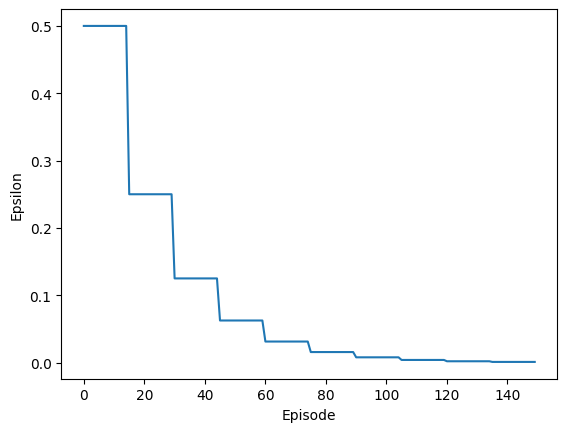

In [32]:
%matplotlib inline

eps = 0.5
epis = 150
epoch = 15

plt.plot([eps*((1-eps)**(i//epoch)) for i in range(epis)])
plt.xlabel('Episode')
plt.ylabel('Epsilon');

In [33]:
def train(policy, episodes=150):
    if policy == 'sarsa':
        learning_alg = sarsa
    elif policy == 'q-learning':
        learning_alg = q_learning
    else:
        raise ValueError("choose 'sarsa' or 'q-learning'")
    
    epoch_length = 15
    
    # Initialise the rewards vector and state-action values array
    rewards = np.zeros(episodes)
    q_value = np.zeros(Q_dims)
    
    print('Training {}...'.format(policy))
    for i in tqdm(range(0, episodes)):
        eps = epsilon*((1-epsilon)**(i//epoch_length))
        rewards[i] = learning_alg(q_value, eps=eps)
    
    return q_value, rewards

In [34]:
q_sarsa, rewards_sarsa = train('sarsa')
q_q_learning, rewards_q_learning = train('q-learning')

Training sarsa...


100%|█████████████████████████████████████████| 150/150 [01:48<00:00,  1.39it/s]


Training q-learning...


100%|█████████████████████████████████████████| 150/150 [02:06<00:00,  1.19it/s]


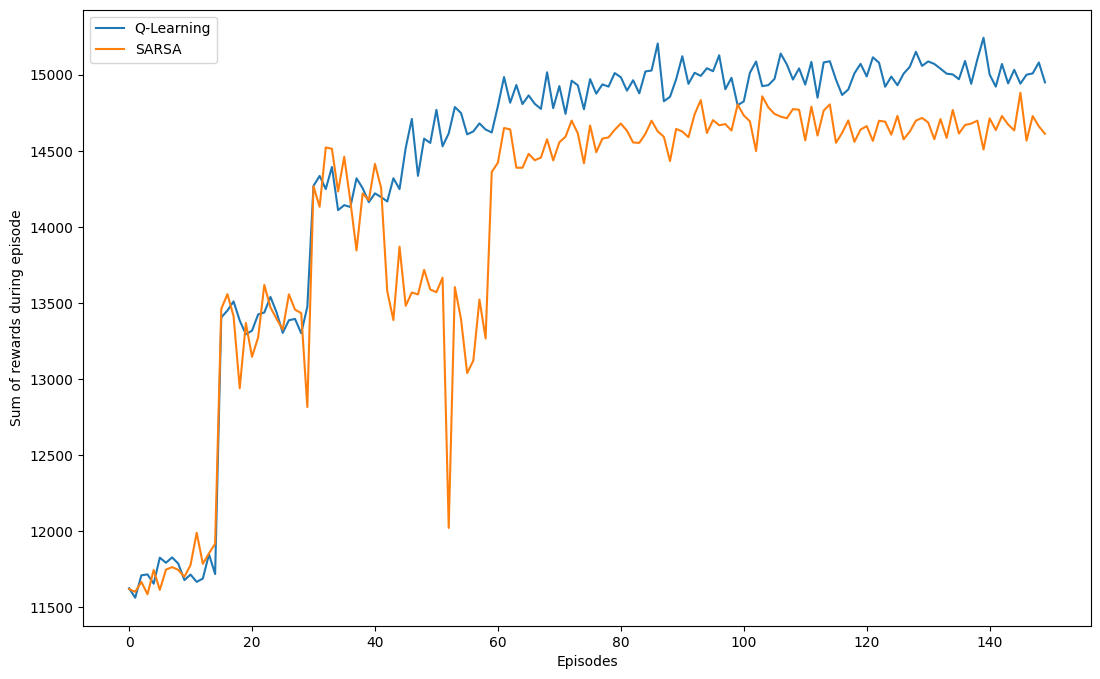

In [35]:
%matplotlib inline
plt.figure(figsize=(13,8))
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_sarsa, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend();

In [36]:
view_strategy = q_q_learning
#view_strategy = q_sarsa